Following along U-Net https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K

import tensorflow as tf
import utility as util

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'
TENSORBOARD_PATH = '../output/run_'
LABEL_FILE_PATH = '../input/stage1_train_labels.csv'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                    preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')


Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:23<00:00,  8.05it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 90.43it/s]

Done!


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


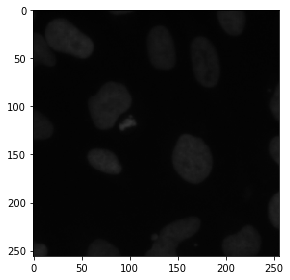

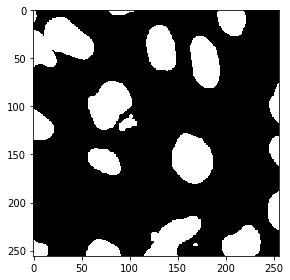

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def mean_iou_fix(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.int32)
    thresholds = np.arange(0.5, 1.0, 0.05, dtype=np.float32)
    tp, tp_up_opt = tf.metrics.true_positives_at_thresholds(y_true, y_pred, thresholds)
    fp, fp_up_opt = tf.metrics.false_positives_at_thresholds(y_true, y_pred, thresholds)
    fn, fn_up_opt = tf.metrics.false_negatives_at_thresholds(y_true, y_pred, thresholds)
    
    K.get_session().run(tf.local_variables_initializer())

    with tf.control_dependencies([tp_up_opt, fp_up_opt, fn_up_opt]):
            tp = tf.identity(tp)
            fp = tf.identity(fp)
            fn = tf.identity(fn)
    iou = tf.divide(tp, tf.add(tf.add(tp, fp), fn))
    return tf.divide(tf.reduce_sum(iou), tf.reduce_mean(thresholds))

Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [8]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

#compress
# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
# c1 = Dropout(0.1) (c1)
# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
# p1 = MaxPooling2D((2, 2)) (c1)

# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# c2 = Dropout(0.1) (c2)
# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
# p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.1) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.1) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
p6 = MaxPooling2D(pool_size=(2, 2)) (c6)

c7 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p6)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

# expand
u1 = Conv2DTranspose(512, (2, 2), strides=(2,2), padding='same') (c7)
u1 = concatenate([u1, c6])
c8 = Conv2D(512, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (u1)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(512, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c8)
u2 = concatenate([u2, c5])
c9 = Conv2D(256, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (u2)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(256, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c9)
u3 = concatenate([u3, c4])
c10 = Conv2D(128, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (u3)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(128, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (c10)

u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c10)
u4 = concatenate([u4, c3])
c11 = Conv2D(64, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (u4)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(64, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (c11)

# u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c11)
# u5 = concatenate([u5, c2])
# c12 = Conv2D(32, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (u5)
# c12 = Dropout(0.1) (c12)
# c12 = Conv2D(32, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (c12)

# u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c12)
# u6 = concatenate([u6, c1], axis=3)
# c13 = Conv2D(16, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c13 = Dropout(0.1) (c13)
# c13 = Conv2D(16, (3, 3), dilation_rate=3, activation='elu', kernel_initializer='he_normal', padding='same') (c13)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 1792        lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 64) 0           conv2d_20[0][0]                  
____________________________________

In [9]:
model_no = 19
modelName = util.makeModelName(model_no)
submissionName = util.makeSubmissionName(model_no)

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=20, verbose=1)
tensorboard = TensorBoard(log_dir=TENSORBOARD_PATH + str(model_no))
checkpointer = ModelCheckpoint(modelName, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=200, 
                    callbacks=[checkpointer, tensorboard, earlystopper])

Train on 603 samples, validate on 67 samples
Epoch 1/200
603/603 [==============================] - 44s 73ms/step - loss: 0.8084 - mean_iou: 0.4164 - val_loss: 0.3167 - val_mean_iou: 0.4364
Epoch 2/200
603/603 [==============================] - 31s 51ms/step - loss: 0.2341 - mean_iou: 0.4681 - val_loss: 0.1861 - val_mean_iou: 0.5104
Epoch 3/200
603/603 [==============================] - 28s 46ms/step - loss: 0.1977 - mean_iou: 0.5416 - val_loss: 0.1927 - val_mean_iou: 0.5661
Epoch 4/200
603/603 [==============================] - 30s 50ms/step - loss: 0.1375 - mean_iou: 0.5879 - val_loss: 0.1382 - val_mean_iou: 0.6107
Epoch 5/200
603/603 [==============================] - 28s 46ms/step - loss: 0.1202 - mean_iou: 0.6290 - val_loss: 0.1394 - val_mean_iou: 0.6458
Epoch 6/200
603/603 [==============================] - 31s 51ms/step - loss: 0.1059 - mean_iou: 0.6597 - val_loss: 0.1308 - val_mean_iou: 0.6721
Epoch 7/200
603/603 [==============================] - 30s 50ms/step - loss: 0.1064 -

Epoch 57/200
603/603 [==============================] - 29s 48ms/step - loss: 0.0714 - mean_iou: 0.8289 - val_loss: 0.0896 - val_mean_iou: 0.8292
Epoch 58/200
603/603 [==============================] - 29s 48ms/step - loss: 0.0703 - mean_iou: 0.8295 - val_loss: 0.0884 - val_mean_iou: 0.8298
Epoch 59/200
603/603 [==============================] - 29s 48ms/step - loss: 0.0714 - mean_iou: 0.8301 - val_loss: 0.0911 - val_mean_iou: 0.8304
Epoch 60/200
603/603 [==============================] - 29s 48ms/step - loss: 0.0707 - mean_iou: 0.8306 - val_loss: 0.0879 - val_mean_iou: 0.8309
Epoch 61/200
603/603 [==============================] - 29s 48ms/step - loss: 0.0705 - mean_iou: 0.8312 - val_loss: 0.0857 - val_mean_iou: 0.8315
Epoch 62/200
603/603 [==============================] - 29s 49ms/step - loss: 0.0706 - mean_iou: 0.8318 - val_loss: 0.0855 - val_mean_iou: 0.8320
Epoch 63/200
603/603 [==============================] - 31s 52ms/step - loss: 0.0704 - mean_iou: 0.8323 - val_loss: 0.0852 -

In [11]:
# Predict on train, val and test
model = load_model(modelName, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 1s 16ms/step


In [12]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

168


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


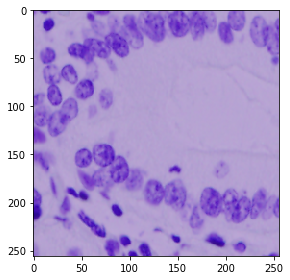

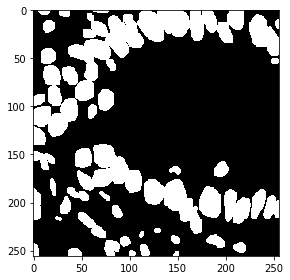

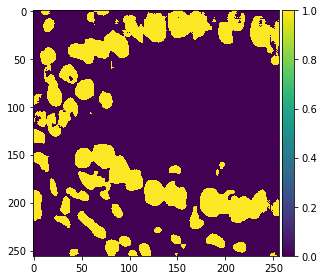

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
# ix = 311
print(ix)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

56


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


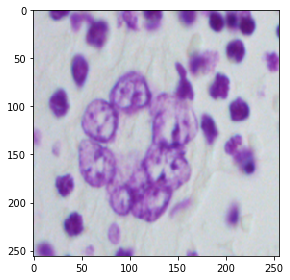

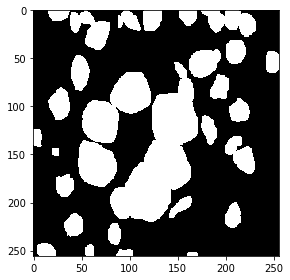

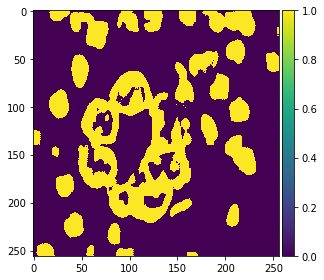

In [23]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
ix = 56
print(ix) #56
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [15]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [16]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [17]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(submissionName, index=False)